# 0. Import libraries

In [1]:
import pandas as pd
import numpy as np

import torch
from torchvision import transforms
import torch.nn as nn

from sklearn.metrics import *

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Explore the data:

### Reading csv and counting entries:
We create a pandas dataframe for both the training and testing datasets. Therefore the further datamodel will directly obtain the dataframe to not duplicate the reading of the data.

In [2]:
train_df = pd.read_csv('./input/train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

test_df = pd.read_csv('./input/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of training samples: 42000
Number of training pixels: 784
Number of classes: 10
Number of train samples: 28000
Number of test pixels: 784


### Display some images with its labels from training set:

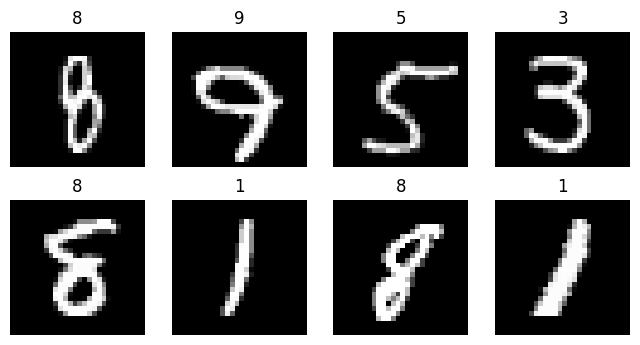

In [3]:
figure = plt.figure(figsize=(8, 4))
cols, rows = 4, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_df), size=(1,)).item()
    img = np.array((train_df.iloc[sample_idx, 1:].values).reshape(28, 28))
    label = train_df.iloc[sample_idx, 0]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img,cmap="gray")
plt.show()

### Histogram of the classes (0-9)
We display the histogram to check if we have class imbalance, which we do not have because the dataset contains roughly the same number of samples for each label.

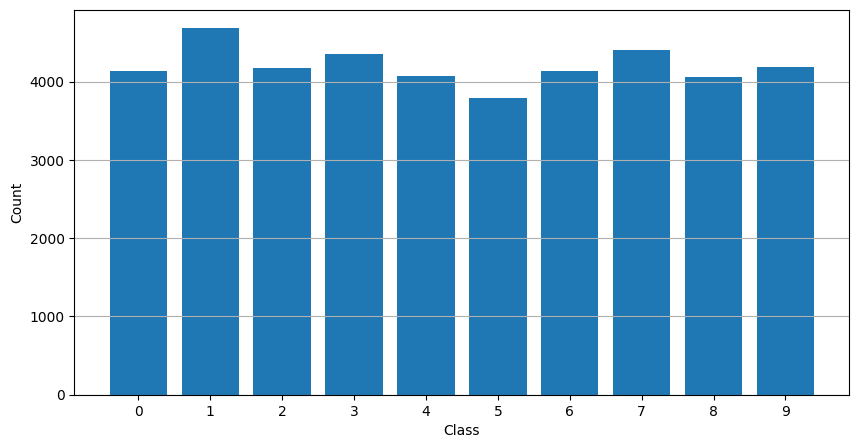

In [4]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.grid('on', axis='y')

# 2. Modeling and Creating Data for Training and Validation:

### Data model:
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.
- The __init__ function is run once when instantiating the Dataset object: in our case, as the data has been already red from the csv and converted to a dataframe, the data is directly this dataframe to which the transformations (if any) will be attached to be performed.
- The __len__ function simply returns the length of the dataset (number of samples).
- The __getitem__ function loads and returns a sample (image and label) from the dataset at the given index.

In [5]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        label = self.data.iloc[index,0] #first column where the label is
        image = torch.tensor(list(self.data.iloc[index,1:]),dtype=torch.float) #all columns but first
        image = image / image.max() #to set the range to [0,1]
        image = image.reshape(28,28).unsqueeze(0)  #convert from (784) to (28,28)

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label 

### Transforms:
Data does not always come in its final processed form that is required for training machine learning algorithms. 
We use transforms to perform some manipulation of the data and make it suitable for training.
For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors.

In [6]:
transform_train = transforms.Compose([
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

### Creating datasets:
The batch size should be a trade-off between accuracy and speed:
- A smaller batch size allows the model to learn from each individual example but takes longer to train
- A larger batch size trains faster but may result in the model not capturing the nuances in the data.

Taking into account the size of our dataset, and that usually the batch size is taken as a power of 2, it has been decided to use 64. (note that if overfitting would have been seen, it would have been increased)

In [7]:
BATCH_SIZE = 64
TRAINING_SIZE = 0.9

full_training_dataset = CustomImageDataset(train_df, transform=transform_train)
training_train_sample, training_valid_sample = torch.utils.data.random_split(full_training_dataset, [TRAINING_SIZE, 1- TRAINING_SIZE])

train_loader = torch.utils.data.DataLoader(training_train_sample, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(training_valid_sample, batch_size=BATCH_SIZE, shuffle=True)

# 3. Building the neural network:
Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks needed to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

### Define the network structure:

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = torch.nn.functional.max_pool2d(torch.nn.functional.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
print(model)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# 4. Training and evaluation:
### 4.1 Training the model and computing the losses/accuracies 
To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. 
The most important hyperparameters here are the **number of epochs** and the **learning rate**:

- With a small learning rate, the training process will take more time but a high learning rate may cause overshooting the global optimum, meaning we would never reach a converging point.
- The number of epochs is how many times we pass the input data to our CNN, meaning that the higher this number, the more our network "learns". This affects directly the time it will take and has a close relation to how complex the task is, being necessary more epochs the harder the task is.

The values chosen for this parameters are purely experimental (with a learning rate higher than 1e-2 we have some overshooting and after 8-10 epochs, the losses being to oscillate around the same values, showing no improvement). 

Also, for our **optimization algorithm** we have chosen stochastic gradient descent (SGD) but others work fine such as the Adam algorithm.

In [9]:
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [10]:
epochs = 10
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(1, epochs+1):

    # TRAINING!!
    training_loss = 0.0
    training_accuracy = 0
    total = 0
    correct = 0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # Clear the gradients, do this because gradients are accumulated.
        optim.zero_grad()
        # Forward pass, get our log-probabilities.
        ps = model(inputs)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(ps.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        training_accuracy+= correct / total
        
        # Compute the loss (how far is the output from being correct).
        loss = criterion(ps, labels)
        # Backpropagate this error through the network. 
        # Autograd calculates and stores the gradients for each model parameter in the parameter’s .grad attribute.
        loss.backward()    
        # initiate gradient descent. The optimizer adjusts each parameter by its gradient stored in .grad.
        optim.step()

        training_loss += loss.item()


    # VALIDATION!!
    else:
        valid_loss = 0
        valid_accuracy = 0
        correct = 0
        total = 0

        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in valid_loader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = model(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                valid_accuracy+= correct / total

                valid_loss += criterion(outputs, labels)

        model.train() # change the network to training mode
        
        train_losses.append(training_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_accuracy/len(valid_loader))
        train_accuracies.append(training_accuracy/len(train_loader))

        network_learned = valid_loss < valid_loss_min

        print(f"Epoch: {epoch}/{epochs}.. ",
                f"Training Loss: {training_loss/len(train_loader):.3f}.. ",
                f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. ",
                f"Training Accuracy: {training_accuracy/len(train_loader):.3f}",
                f"Valid Accuracy: {valid_accuracy/len(valid_loader):.3f}")
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'CNN_model.pt')
            print('Detected network improvement, saving current model')


Epoch: 1/10..  Training Loss: 0.541..  Validation Loss: 0.132..  Training Accuracy: 0.610 Valid Accuracy: 0.960
Detected network improvement, saving current model
Epoch: 2/10..  Training Loss: 0.095..  Validation Loss: 0.081..  Training Accuracy: 0.966 Valid Accuracy: 0.970
Detected network improvement, saving current model
Epoch: 3/10..  Training Loss: 0.062..  Validation Loss: 0.077..  Training Accuracy: 0.980 Valid Accuracy: 0.977
Detected network improvement, saving current model
Epoch: 4/10..  Training Loss: 0.045..  Validation Loss: 0.051..  Training Accuracy: 0.986 Valid Accuracy: 0.985
Detected network improvement, saving current model
Epoch: 5/10..  Training Loss: 0.039..  Validation Loss: 0.052..  Training Accuracy: 0.987 Valid Accuracy: 0.985
Epoch: 6/10..  Training Loss: 0.031..  Validation Loss: 0.046..  Training Accuracy: 0.991 Valid Accuracy: 0.987
Detected network improvement, saving current model
Epoch: 7/10..  Training Loss: 0.027..  Validation Loss: 0.047..  Training

After the training process has finished, we can observe if it has been succesfull plotting both the training/validation losses and accuracies. 

In our case, we are interested in the **difference between the training and validation accuracies**. If we were to have a large gap between them (being the training accuracy larger of course), it would mean that the model is overfitted. This implies that the model excels at images contained in the training dataset but performs poorly with new/unknown data. 

For our model, this difference between the accuracies is rather small (0.995 to 0.985), meaning the model performs well and is not overfitted.

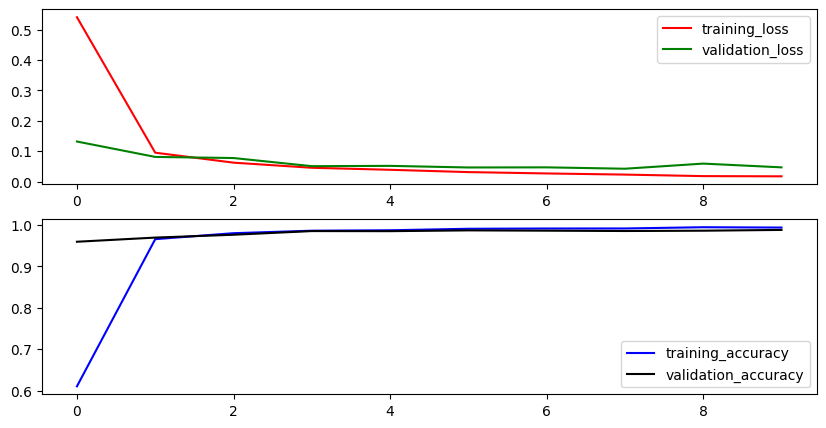

In [11]:
plt.subplot(2, 1, 1)
line1 = plt.plot(train_losses, c='red')
line2 = plt.plot(valid_losses, c='green')
plt.legend(['training_loss', 'validation_loss'])

plt.subplot(2, 1, 2)
line3 = plt.plot(train_accuracies, c='blue')
line4 = plt.plot(valid_accuracies, c='black')

plt.legend(['training_accuracy', 'validation_accuracy'])
plt.show()

### 4.2 Computing the accuracy per class and the confusion matrix:

Some analysis to determine where is our model failing to classify and improve accuracy can be done in two ways. 

The first one is computing the **accuracy for each class separately**. 

In [12]:
# prepare to count predictions for each class
classes = ('0','1','2','3','4','5','6','7','8','9')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 99.5 %
Accuracy for class: 1     is 99.2 %
Accuracy for class: 2     is 99.3 %
Accuracy for class: 3     is 99.5 %
Accuracy for class: 4     is 98.7 %
Accuracy for class: 5     is 98.3 %
Accuracy for class: 6     is 98.4 %
Accuracy for class: 7     is 98.6 %
Accuracy for class: 8     is 98.3 %
Accuracy for class: 9     is 98.0 %


Now, to check the misclassification we can calculate the **Confusion Matrix**. This will give us a matrix comparing the true labels (the actual value of the input) and the predicted label produced by our model.

This way we can observe that for our model, some 6's are being mislabeled as 0's. We also have computed the accuracy for the valid images, obtaining 98.7%. This result is fairly good but it **can be improved using other types of optimization algorithm and increasing the number of epochs at expense of computation time**. 

Accuracy of the network on valid images:  0.9880924029530841


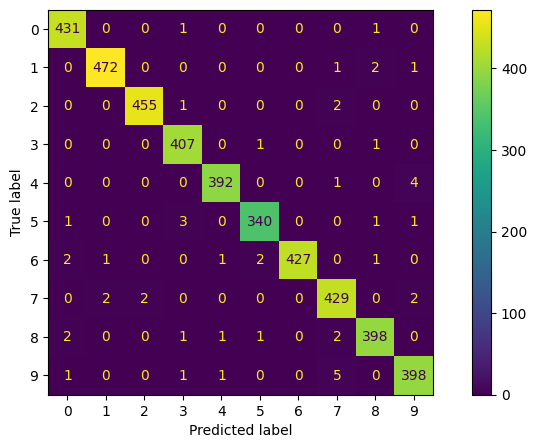

In [13]:
correct = 0
total = 0
predicted_list =  []
labels_list = []
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted)
        total += labels.size(0)
        labels_list.append(labels)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on valid images: ', correct/total)
labels_tensor = torch.cat(labels_list,dim=0)
predicted_tensor = torch.cat(predicted_list,dim=0)
cm = confusion_matrix(labels_tensor,predicted_tensor)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 5. Submittion CSV for Kaggle:

Finally, **to test our CNN we use the _test.csv_ in which the images are not labeled**. We will output the predictions to a CSV file which we can submit to Kaggle and be given an accuracy for our model. 

This is done in the same way: first process the dataset (converting to tensor and normalizing the values as well as resizing to 28x28), giving this as input to our network and storing the predicted values to the build a CSV file with the ID of the image (number of row) and the predicted label. This CSV file will have the name _submition.csv_.

Submitting it to Kaggle we obtain an **accuracy of 97.1%**.

In [14]:
test_df = pd.read_csv('./input/test.csv')
test_df.values.shape
test_tensor = torch.tensor(test_df.values, dtype=torch.float) / 255
test_tensor = test_tensor.view(-1, 1, 28, 28)
outputs = model(test_tensor)
_, predicted = torch.max(outputs, 1)
submit_df = pd.DataFrame({'ImageId': np.arange(1, 28001), 'Label': predicted.numpy()})
submit_df.to_csv('submition.csv', index=False)